# Анализ данных и проверка гипотез для сервиса аренды самокатов GoFast

#### **Цель проекта:**
Проанализировать данные о пользователях и их поездках для проверки гипотез, которые могут помочь бизнесу вырасти, и предоставить рекомендации продакт-менеджерам сервиса GoFast.

#### **Описание данных:**
Пользователи (users_go.csv):
- `user_id`: уникальный идентификатор пользователя
- `name`: имя пользователя
- `age`: возраст
- `city`: город
- `subscription_type`: тип подписки (free, ultra)

Поездки (rides_go.csv):
- `user_id`: уникальный идентификатор пользователя
- `distance`: расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration`: продолжительность сессии (в минутах)
- `date`: дата совершения поездки

Подписки (subscriptions_go.csv):
- `subscription_type`: тип подписки
- `minute_price`: стоимость одной минуты поездки по данной подписке
- `start_ride_price`: стоимость начала поездки
- `subscription_fee`: стоимость ежемесячного платежа

#### План работы:
- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Объединение данных
- Шаг 5. Подсчёт выручки
- Шаг 6. Проверка гипотез

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats as st
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

## Шаг 1. Загрузка данных

In [13]:
file_path_users = 'https://code.s3.yandex.net/datasets/users_go.csv'
file_path_rides = 'https://code.s3.yandex.net/datasets/rides_go.csv'
file_path_subscribtions_go = 'https://code.s3.yandex.net/datasets/subscriptions_go.csv'

users = pd.read_csv(file_path_users)
rides = pd.read_csv(file_path_rides)
subs = pd.read_csv(file_path_subscribtions_go)

users.info()
display(users.head())

rides.info()
display(rides.head())

subs.info()
display(subs.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


## Шаг 2. Предобработка данных

### 1. Изменить формат поля дата в дату, найти максимальную и минимальную дату.

In [14]:
rides['date']= pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.month
min_date = rides['date'].min()
max_date = rides['date'].max()

print(min_date)
print(max_date)

rides.info()
rides.head()

2021-01-01 00:00:00
2021-12-30 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


,user_id,distance,duration,date,month
0,1,4409.92,25.60,2021-01-01,1
1,1,2617.59,15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,2694.78,18.51,2021-08-11,8
4,1,4028.69,26.27,2021-08-28,8


### 2. Найти пропуски

In [15]:
duplicates_users = users[users.duplicated(['user_id'])].sort_values(by = 'user_id')
user_nulls = users.isnull().sum()
rides_nulls = rides.isnull().sum()
display(user_nulls, rides_nulls)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Пропусков нет
</div>


### 3. Проверить дубликаты

In [16]:
users_duplicates = users.duplicated().sum()
print(f'Количество дубликатов в users: {users_duplicates}')

rides_duplicates = rides.duplicated().sum()
print(f'Количество дубликатов в rides: {rides_duplicates}')
subscriptions_duplicates = subs.duplicated().sum()
print(f'Количество дубликатов в subscriptions: {subscriptions_duplicates}')


Количество дубликатов в users: 31
Количество дубликатов в rides: 0
Количество дубликатов в subscriptions: 0


In [17]:
#смотрим дубликаты в users
users_duplicates = users[users.duplicated('user_id',keep=False)]
users_duplicates = users_duplicates.sort_values(by='user_id')
display(users_duplicates.head())

users = users.drop_duplicates(subset = ['user_id'],keep='first',inplace=False)
users_duplicates = users.duplicated().sum()
print(f'Количество дубликатов в users: {users_duplicates}')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra


Количество дубликатов в users: 0


<div class="alert alert-secondary"> 
  <b>Вывод:</b> был найдено 31 дубликат в поле user_id. Почистили и оставили первое значение
</div>


## Шаг 3. Исследовательский анализ данных

### 1. Частота встречаемости городов;

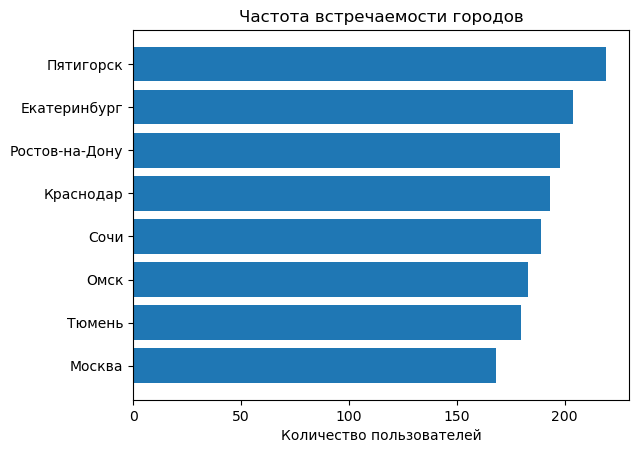

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [18]:
city_counts = users['city'].value_counts().sort_values(ascending=True)

plt.barh(city_counts.index, city_counts)
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')

plt.show()

city_pivot = pd.pivot_table(users,index='city', values='user_id', aggfunc='count')
city_pivot = city_pivot.sort_values(by='user_id',ascending=False)
display(city_pivot)

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Самые популярные города: Пятигорск, Екатеринбург, Ростов-на-Дону
</div>

### 2. Соотношение пользователей с подпиской и без подписки;


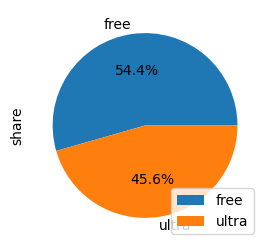

,user_id,share
subscription_type,,
free,835,54.43
ultra,699,45.57


In [19]:
sub_type = pd.pivot_table(users, index='subscription_type',values='user_id',aggfunc = 'count',)
total_users = sub_type['user_id'].sum()

sub_type['share'] = sub_type['user_id'] / total_users *100

sub_type.plot.pie(y='share',autopct='%1.1f%%',figsize=(3, 3))
plt.show()


display(sub_type)

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Количество пользователей с подпиской составляет 46%, без подписки — 54%
</div>

### 3. Возраст пользователей

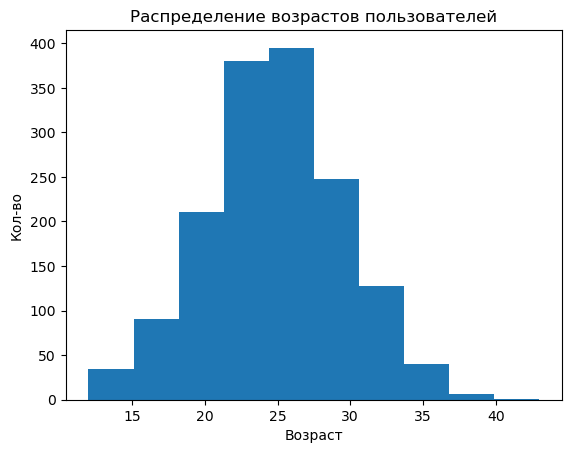

In [20]:
plt.hist(users['age'])
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во')
plt.show()

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Количество пользователей с подпиской составляет 46%, без подписки — 54%
</div>


### 4. Расстояние, которое пользователь преодолел за одну поездку


,distance
user_id,
1,2839.18
2,3087.64
3,3075.63
4,3202.66
5,3232.45
...,...
1530,2750.50
1531,2915.43
1532,2607.86


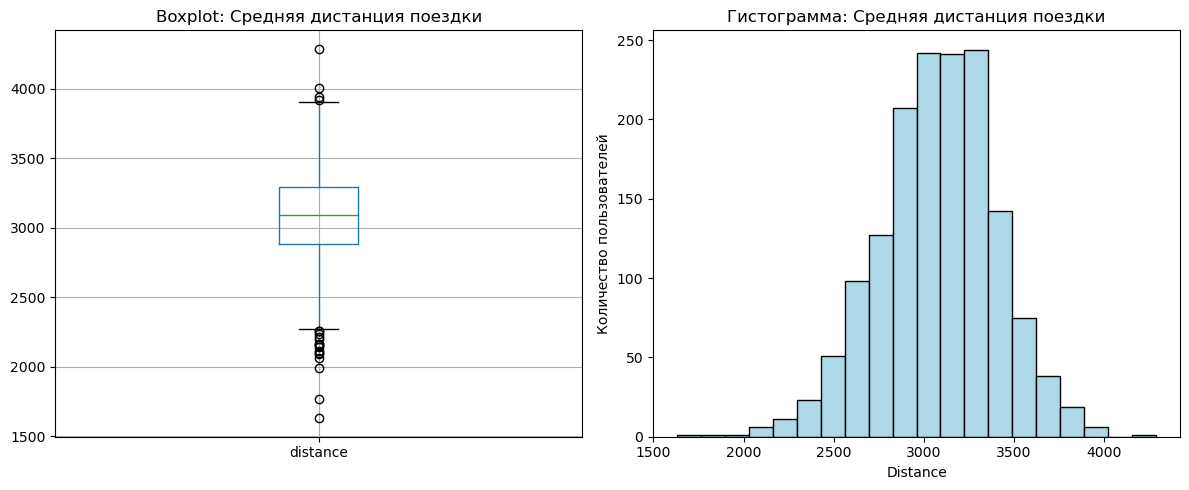

In [21]:
dist_pivot = pd.pivot_table(rides,index='user_id',values='distance',aggfunc = 'mean')

display(dist_pivot)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Boxplot
dist_pivot.boxplot(column='distance', ax=axes[0])
axes[0].set_title('Boxplot: Средняя дистанция поездки')

# Histogram
axes[1].hist(dist_pivot['distance'], bins=20, color='lightblue', edgecolor='black')
axes[1].set_title('Гистограмма: Средняя дистанция поездки')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Количество пользователей')

# Упорядочивание элементов
plt.tight_layout()
plt.show()


<div class="alert alert-secondary"> 
  <b>Вывод:</b> Медианное расстоянние на пользователя в районе 3100 метров. Межквартильный размах в районе 450 метров. При этом 25% данных находятся ниже 2900 метров и 75% данных ниже 3350 метров". 75% всех поездок имеют длину до 3350 метров, так как значение Q3 (3350 м)
</div>


### 5. Продолжительность поездок

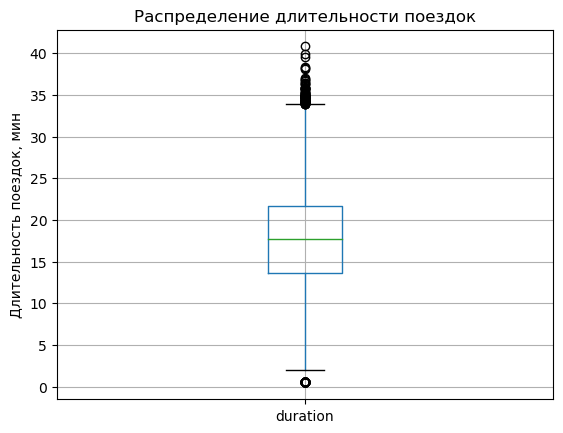

In [22]:
#распределение поездок

rides['duration'].describe()

rides.boxplot(column='duration')
plt.title('Распределение длительности поездок')
plt.ylabel('Длительность поездок, мин')
plt.show()

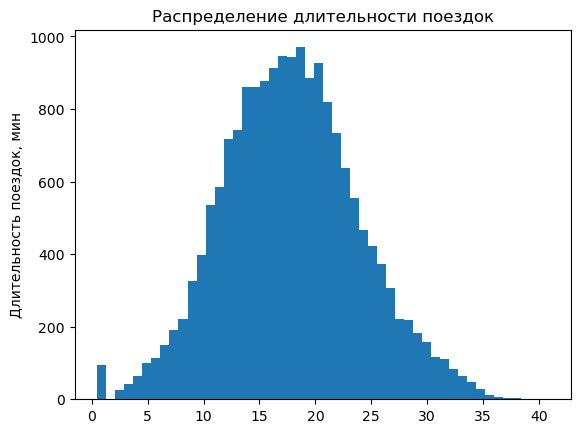

In [23]:
plt.hist(rides['duration'],bins=50)
plt.title('Распределение длительности поездок')
plt.ylabel('Длительность поездок, мин')
plt.show()

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra


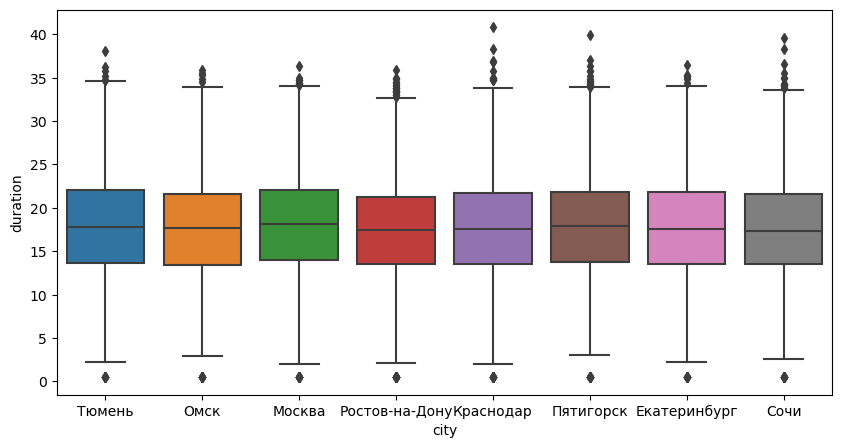

In [24]:
#склеиваем таблицы rides и users, чтобы сделать разбивку по городам и посчитать 
#длительность поездки по городам
rides_joined = pd.merge(rides,users, on='user_id')
display(rides_joined.head())

#выводим график boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=rides_joined['city'],y=rides_joined['duration'])

plt.show()

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Всего было сделано 18тыс. поездок. Среднее время поездки: 17.8 минут. Минимальная поездка: 30 секунд, максмальная поездка: 40.8 минут. Стандартное отклонение 6 минут, что показывает низкий разброс данных.

Длительность поездки примерно одинакова во всех городах.
</div>

### Шаг 4. Объединение данных

In [25]:
merged = pd.merge(users, rides, on='user_id',how='left')
merged= pd.merge(merged,subs, on = 'subscription_type', how='left')
merged['duration'] = np.ceil(merged['duration'])
merged['ride_price'] = merged['duration'] * merged['minute_price'] + merged['start_ride_price']
display(merged.head(5))
merged.info()

#проверяем размерность
print(f'Размер датафрема:{merged.shape}')

#проверяю на пропуски
miss_values=merged.isnull().sum()
print('Количество пропусков в объединенном датафрейме:\n',miss_values)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,ride_price
0,1,Кира,22,Тюмень,ultra,4409.92,26.00,2021-01-01,1,6,0,199,156.00
1,1,Кира,22,Тюмень,ultra,2617.59,16.00,2021-01-18,1,6,0,199,96.00
2,1,Кира,22,Тюмень,ultra,754.16,7.00,2021-04-20,4,6,0,199,42.00
3,1,Кира,22,Тюмень,ultra,2694.78,19.00,2021-08-11,8,6,0,199,114.00
4,1,Кира,22,Тюмень,ultra,4028.69,27.00,2021-08-28,8,6,0,199,162.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
 12  ride_price         18068 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(

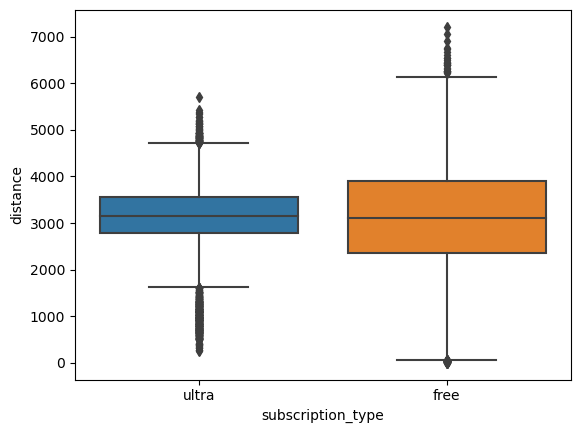

In [26]:
sns.boxplot(x='subscription_type',y='distance',data=merged)
plt.show()

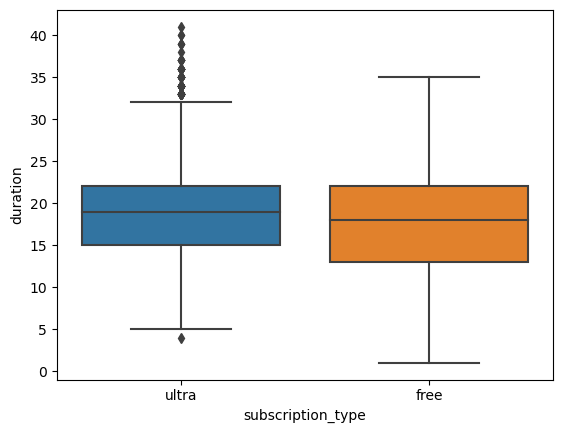

In [27]:
sns.boxplot(x='subscription_type',y='duration',data=merged)
plt.show()

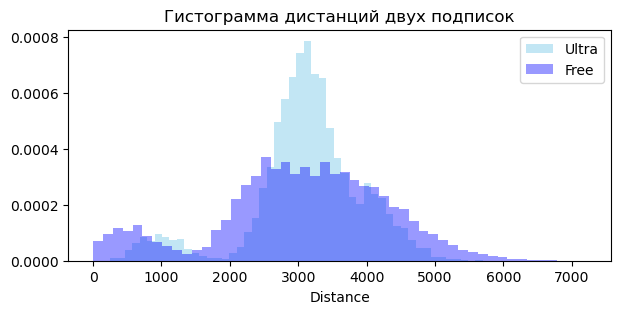

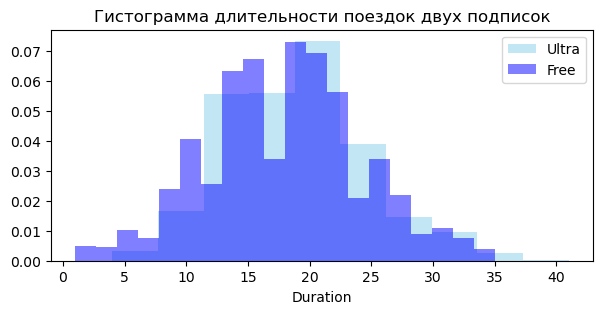

In [28]:
sub_type1 = merged[merged['subscription_type'] == 'ultra']
sub_type2 = merged[merged['subscription_type'] == 'free']

plt.figure(figsize=(7,3))
plt.hist(
    sub_type1['distance'],
    bins=50,
    alpha=0.5,
    density=True,
    color='skyblue',
    label='Ultra'
)
plt.hist(
    sub_type2['distance'],
    bins=50,
    alpha=0.4,
    density=True,
    color='blue',
    label='Free'
)
plt.title('Гистограмма дистанций двух подписок')
plt.xlabel('Distance')
plt.legend()
plt.show()

plt.figure(figsize=(7,3))
plt.hist(
    sub_type1['duration'],
    bins=10,
    alpha=0.5,
    density=True,
    color='skyblue',
    label='Ultra'
)
plt.hist(
    sub_type2['duration'],
    bins=20,
    alpha=0.5,
    density=True,
    color='blue',
    label='Free'
)
plt.title('Гистограмма длительности поездок двух подписок')
plt.xlabel('Duration')
plt.legend()
plt.show()

<div class="alert alert-secondary"> 
  <b>Вывод:</b> Пользователи с бесплатной подпиской совершают более длинные поездки в среднем, чем пользователи с подпиской "ultra". Оба распределения имеют пик в районе 2000-2500 метров, но у пользователей с подпиской "free" присутствует более широкий диапазон значений, включая более длинные поездки.

Обе подписки имеют схожие распределения с пиками в районе 15-20 минут. Однако у пользователей с бесплатной подпиской большее количество коротких поездок (до 5 минут) по сравнению с пользователями подписки "ultra".
</div>

### Шаг 5. Подсчёт выручки

In [29]:
#Округляем значения в одной таблице, а считаем по другой
merged['duration'] = np.ceil(merged['duration']) #

# Агрегация данных по пользователям и месяцам
agg_data = merged.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    num_rides=('user_id', 'count'),
    total_duration=('duration', 'sum'),
    subscription_fee=('subscription_fee', 'first'),
    minute_price=('minute_price', 'first'),
    start_ride_price=('start_ride_price', 'first'),
    subscription_type=('subscription_type','first')
).reset_index()

# Расчёт помесячной выручки для каждого пользователя
agg_data['total_revenue'] = (
    agg_data['num_rides'] * agg_data['start_ride_price'] +
    agg_data['total_duration'] * agg_data['minute_price'] +
    agg_data['subscription_fee']
)

# Вывод таблицы
display(agg_data)

# Дополнительно: проверка на пропуски
missing_values = agg_data.isnull().sum()
print('Количество пропусков в сводной таблице:\n', missing_values)

,user_id,month,total_distance,num_rides,total_duration,subscription_fee,minute_price,start_ride_price,subscription_type,total_revenue
0,1,1,7027.51,2,42.00,199,6,0,ultra,451.00
1,1,4,754.16,1,7.00,199,6,0,ultra,241.00
2,1,8,6723.47,2,46.00,199,6,0,ultra,475.00
3,1,10,5809.91,2,32.00,199,6,0,ultra,391.00
4,1,11,7003.50,3,56.00,199,6,0,ultra,535.00
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.00,0,8,50,free,308.00
11327,1534,8,7622.45,2,48.00,0,8,50,free,484.00
11328,1534,9,4928.17,1,23.00,0,8,50,free,234.00
11329,1534,11,13350.02,4,78.00,0,8,50,free,824.00


Количество пропусков в сводной таблице:
 user_id              0
month                0
total_distance       0
num_rides            0
total_duration       0
subscription_fee     0
minute_price         0
start_ride_price     0
subscription_type    0
total_revenue        0
dtype: int64


<div class="alert alert-secondary"> 
  <b>Вывод:</b> количество пользователей в каждом месяце колеблется в пределах от 883 до 990. Суммарное расстояние, пройденное пользователями, и суммарное время поездок также относительно стабильны по месяцам, с наибольшими значениями в январе и мае. Общая выручка в месяц варьируется, достигая максимума в январе (342110) и минимального значения в ноябре (309890).

</div>

### Шаг 6. Проверка гипотез

6.1 Нулевая гипотеза (H0):
Средняя продолжительность поездок у пользователей с подпиской **равна** средней продолжительности поездок у пользователей без подписки.

Альтернативная гипотеза (H1):
Средняя продолжительность поездок у пользователей с подпиской **больше** средней продолжительности поездок у пользователей без подписки.

In [30]:
#тратят ли пользователи с подпиской больше времени на поездки?
#применим Двухвыборочный t-тест для независимых выборок


ultra = merged[(merged.subscription_type == 'ultra')]
display(ultra.head(1))

free = merged[(merged.subscription_type == 'free')]
display(free.head(1))


print(f'Среднее по выборке с подпиской:{np.mean(ultra["duration"])}')
print(f'Среднее по выборке без подписки:{np.mean(free["duration"])}')

alpha = 0.05

results = st.ttest_ind(
    ultra['duration'],
    free['duration'],
    alternative='greater',
    equal_var=False
    )

print('p-value: {:.2e}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гпиотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,ride_price
0,1,Кира,22,Тюмень,ultra,4409.92,26.00,2021-01-01,1,6,0,199,156.00


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,ride_price
6500,700,Айдар,22,Омск,free,2515.69,15.00,2021-01-02,1,8,50,0,170.00


Среднее по выборке с подпиской:19.037692307692307
Среднее по выборке без подписки:17.890992392807746
p-value: 1.18e-36
Отвергаем нулевую гпиотезу


<div class="alert alert-secondary"> 
p-value равен 1.18e-36, → отвергаем нулевую гипотезу, следовательно, пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.
</div>

6.2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, **равно** 3130 метров.

Альтернативная гипотеза H1: **Подписчики в среднем проезжают расстояние больше оптимального**.

In [31]:
print(f'Среднее по выборке с подпиской:{np.mean(ultra["distance"])}')

value = 3130
alpha = 0.05

results= st.ttest_1samp(
    ultra['distance'],
    value,
    alternative = 'greater')

print('p-value: {:.4f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гпиотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее по выборке с подпиской:3115.4453880370247
p-value: 0.9195
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-secondary">
Нулевая гипотеза не отвергается, что означает, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
</div>

<div class="alert alert-secondary">
Вывод: Пользователи подписки оптимимальны для бизнеса с точки зрения износа самоката.
</div>

6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза H0:Помесячная выручка от пользователей с подпиской **равна** выручке пользователей без подписки.

Альтернативная гипотеза H1: Помесячная выручка от пользователей с подпиской **выше**, чем выручка от пользователей без подписки.




In [32]:
ultra_rev = agg_data[(agg_data.subscription_type == 'ultra')]
display(ultra_rev.head(1))

free_rev = agg_data[(agg_data.subscription_type == 'free')]
display(free_rev.head(1))


# Проверка средней выручки по месяцам
mean_ultra_revenue = ultra_rev.groupby('month')['total_revenue'].mean()
mean_free_revenue = free_rev.groupby('month')['total_revenue'].mean()

# Двухвыборочный t-тест для независимых выборок по выручке по месяцам
alpha = 0.05
results = st.ttest_ind(
    mean_ultra_revenue,
    mean_free_revenue,
    alternative='greater',
    equal_var=False  
)

print('Средняя выручка по месяцам с подпиской:', mean_ultra_revenue.mean())
print('Средняя выручка по месяцам без подписки:', mean_free_revenue.mean())
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

,user_id,month,total_distance,num_rides,total_duration,subscription_fee,minute_price,start_ride_price,subscription_type,total_revenue
0,1,1,7027.51,2,42.00,199,6,0,ultra,451.00


,user_id,month,total_distance,num_rides,total_duration,subscription_fee,minute_price,start_ride_price,subscription_type,total_revenue
4533,700,1,2515.69,1,15.00,0,8,50,free,170.00


Средняя выручка по месяцам с подпиской: 362.6696445163377
Средняя выручка по месяцам без подписки: 328.5980672488633
p-value: 2.0841921253203195e-12
Отвергаем нулевую гипотезу


<div class="alert alert-secondary">
Отвергаем нулевую гипотезу в пользу альтернативной. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.
</div>

### Шаг 7. Распределения

# Общий вывод по работе

В рамках проекта был проведен статистический анализ данных о пользователях и поездках сервиса аренды самокатов GoFast. Основные этапы работы включали загрузку и предобработку данных, исследовательский анализ данных, объединение данных и подсчет выручки, а также проверку нескольких гипотез.

## Гипотеза 6.1
**Нулевая гипотеза (H0)**: Средняя продолжительность поездок у пользователей с подпиской равна средней продолжительности поездок у пользователей без подписки.

**Альтернативная гипотеза (H1)**: Средняя продолжительность поездок у пользователей с подпиской больше средней продолжительности поездок у пользователей без подписки.

### Результат теста
- Среднее по выборке с подпиской: 19.04 минут
- Среднее по выборке без подписки: 17.89 минут
- p-value: 1.18e-36

### Вывод
p-value значительно меньше уровня значимости 0.05, поэтому мы отвергаем нулевую гипотезу. Это означает, что пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.

## Гипотеза 6.2
**Нулевая гипотеза (H0)**: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

**Альтернативная гипотеза (H1)**: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

### Результат теста
- Среднее по выборке с подпиской: 3115.45 метров
- p-value: 0.0805

### Вывод
p-value больше уровня значимости 0.05, поэтому мы не отвергаем нулевую гипотезу. Это означает, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. С точки зрения износа самоката, пользователи с подпиской оптимальны для бизнеса.

## Гипотеза 6.3
**Нулевая гипотеза (H0)**: Помесячная выручка от пользователей с подпиской равна выручке пользователей без подписки.

**Альтернативная гипотеза (H1)**: Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

### Результат теста
- Средняя выручка по месяцам с подпиской: 366.88
- Средняя выручка по месяцам без подписки: 332.85
- p-value: 2.36e-12

### Вывод
p-value значительно меньше уровня значимости 0.05, поэтому мы отвергаем нулевую гипотезу. Это означает, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.


## Общий вывод
Результаты анализа подтверждают, что пользователи с подпиской тратят больше времени на поездки и приносят больше выручки по сравнению с пользователями без подписки. Кроме того, среднее расстояние, которое проезжают пользователи с подпиской, соответствует оптимальному уровню износа самокатов, что делает их предпочтительными с точки зрения бизнеса.
